# My Internship Notebook

## Imports

In [1]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from tensorflow import keras as tfk
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa
import sklearn.model_selection 

from ad import utils
from ad import plots

%load_ext autoreload
%autoreload 2

2023-07-20 14:38:39.073298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Conversion from _file.txt_ to _file.npz_

**Note**: make sure to have all the MC simulations for the Fe, He and p in a format file.txt in a folder called _data_

In [2]:
folder_path = "./data"
file_names = ["fe_events.txt", "he_events.txt", "pr_events.txt"]
output_file = "data_events.npz"

p, He, Fe = utils.convert_data_to_npz(folder_path, file_names, output_file)

The iron file has a shape of (308630, 1028)
The helium file has a shape of (157637, 1028)
The proton file has a shape of (104172, 1028)


Plotting data before applying the cut.

We define the core for each image:
- Take 19 pixels with higher charge
- Exclude those pixels with less than 10 Phe 
- The core charge is computed as the addition of the surviving pixels 

The core charge is used as an estimator to reject the night sky background (NSB)


The M1 array is [1471.      383.25   1192.375  ... 1804.25   2022.5     465.6875]
The M2 array is [2044.75    146.6875 1489.625  ...  313.6562 2359.375   507.5625]


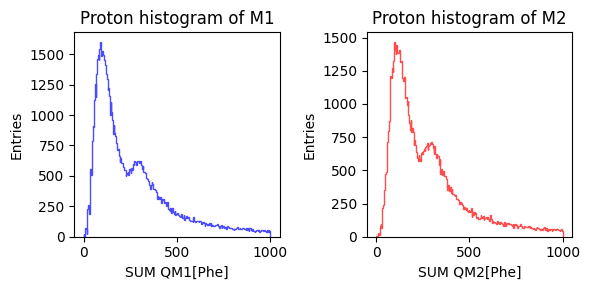

The M1 array is [139.0938   175.9375    69.218704 ... 253.99991   77.5625   724.5625  ]
The M2 array is [ 63.9688    63.8438   102.156204 ... 624.1875   341.7187   594.1875  ]


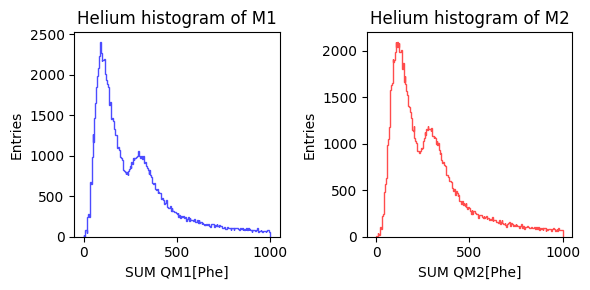

The M1 array is [176.62491 126.5937  181.0936  ... 414.9062  313.43738 386.5625 ]
The M2 array is [ 369.24988  219.4687   147.75    ...  609.125    360.7811  1024.75   ]


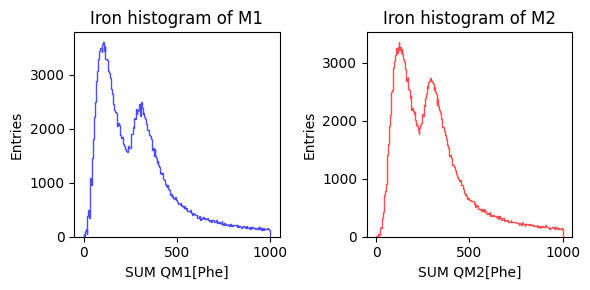

In [3]:
cut = None

M1, M2 = plots.plot_histograms(p , bins=250, range=(0,1000), cut=cut, title='Proton')
M1, M2 = plots.plot_histograms(He, bins=250, range=(0,1000), cut=cut, title='Helium')
M1, M2 = plots.plot_histograms(Fe, bins=250, range=(0,1000), cut=cut, title='Iron')

utils.free_mem()
del M1,M2

## Data Preselection

**CUT** on the core charge is performed to reject the NSB

The final shape of Proton data is (43448, 1028)


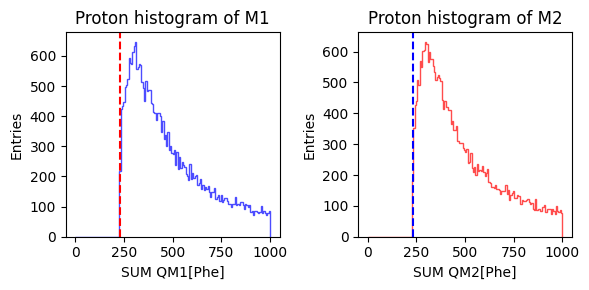

The final shape of Helium data is (68611, 1028)


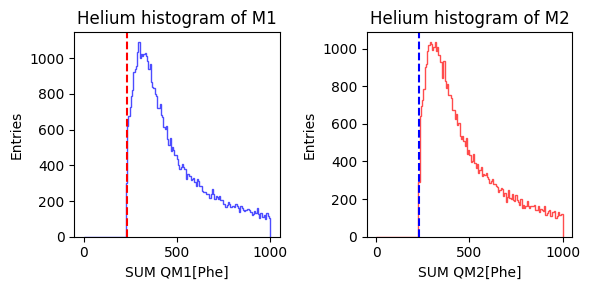

The final shape of Iron data is (155704, 1028)


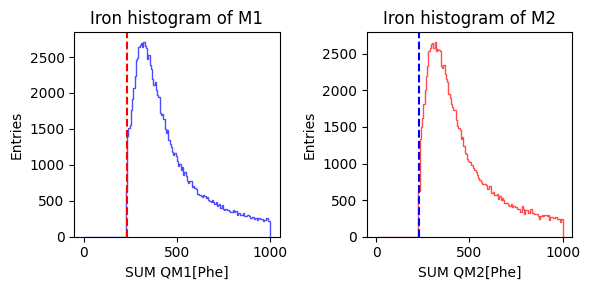

In [4]:
# Choose the cut of data here
cut = 230 #BEST: 230

fp  = plots.cut_data_by_threshold(p , cut=cut, range=(0,1000), title='Proton')
fHe = plots.cut_data_by_threshold(He, cut=cut, range=(0,1000), title='Helium')
fFe = plots.cut_data_by_threshold(Fe, cut=cut, range=(0,1000), title='Iron')

In [5]:
#fHe = fHe[:len(fp)] # if the same statisics are considered for all the species
#fFe = fFe[:len(fp)]

print(fp.shape, fHe.shape, fFe.shape,)

X = np.concatenate((fp, fHe, fFe), axis=0)
print(X.shape)

(43448, 1028) (68611, 1028) (155704, 1028)


(267763, 1028)


## Creation of labels 

In [6]:
yFe = np.zeros((len(fFe), ), dtype = int) 
yFe[:] = 2  
yHe = np.ones((len(fHe), ), dtype = int) 
yp = np.zeros((len(fp), ), dtype = int) 

print(f"label for protons: {yp[:]}" )
print(f"label for helium:  {yHe[:]}")
print(f"label for Iron:    {yFe[:]}")

y = np.concatenate((yp, yHe, yFe), axis=0)
y= tfk.utils.to_categorical(y)

print(f"\n The shape of the concatenated array: {y.shape}")
utils.free_mem()
del yFe, yHe, yp, Fe, He, p, fFe, fHe, fp

label for protons: [0 0 0 ... 0 0 0]
label for helium:  [1 1 1 ... 1 1 1]
label for Iron:    [2 2 2 ... 2 2 2]

 The shape of the concatenated array: (267763, 3)


Splitting the data in training and test

In [7]:
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, train_size = 0.75, shuffle = True) #Best: train = 75%

utils.free_mem()
#del X, y

print(y_train[:4])
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
(200822, 1028) (66941, 1028) (200822, 3) (66941, 3)


## FeedForward Neural Network Model

In [8]:
from ad.models.FFNN import FFNN

model = FFNN(
                name = 'FFNetwork',
                num_classes = 3, # Fe, He, p

                 
                network = dict( layer_sizes = [ 128, 64 ], # BEST: [ 128,64 ]
                                kernel_initializer= 'he_uniform', #BEST : 'he_uniform'
                                kernel_regularizer=regularizers.L2(l2 = 1e-3), #BEST : regularizers.l2(0.001)
                                BN = True, #BEST: TRUE
                                PRelu = True, #BEST: TRUE
                                dropout_rate = None, #BEST: None
                                input_shape = ( 1028, )
                                )
)
model.summary()

Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1028)]            0         
                                                                 
 d0 (Dense)                  (None, 128)               131712    
                                                                 
 bn0 (BatchNormalization)    (None, 128)               512       
                                                                 
 prelu0 (PReLU)              (None, 128)               128       
                                                                 
 d1 (Dense)                  (None, 64)                8256      
                                                                 
 bn1 (BatchNormalization)    (None, 64)                256       
                                                                 
 prelu1 (PReLU)              (None, 64)                6

2023-07-20 14:39:23.005420: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
# Compile the model with the specified metrics
model.network.compile(optimizer='adam', # BEST: 'adam'
                      loss='categorical_crossentropy',
                      metrics=['accuracy', 
                               metrics.AUC(name='AUC'),
                               metrics.Precision(name='prec'), 
                               metrics.Recall(name='rec'),
                               tfa.metrics.F1Score(num_classes=3, average='weighted', name='f1'),
                                ]
                               )

### Training the model
The model isn't very complex, so this should just take a few minutes even on the CPU. If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [10]:
train = False

if train:
    # Define your callbacks
    early_stop = tfk.callbacks.EarlyStopping(monitor='val_loss', verbose=True, patience=4, #BEST: patiente = 4
                                              restore_best_weights=True)
    # reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
    model_checkpoint = ModelCheckpoint('./weights/FFNN/model_weights.h5', 
                                       save_best_only=True,
                                       monitor='val_loss',
                                       mode='max',
                                       verbose=1)

    # Train the model
    start_loop = time.time()
    model.train(x_train, y_train, 
                x_valid, y_valid, 
                epochs=40, 
                batch_size=256, 
                callbacks=[early_stop, model_checkpoint])
    print("\nTotal time taken: %.2f min \n" % ((time.time() - start_loop)/60.) )
    # Save the model weights
    model.network.save_weights('./weights/FFNN.h5')
    model.network.load_weights('./weights/FFNN/model_weights.h5')
else: 
    # Load the saved model weights
    model.network.load_weights('./weights/FFNN/model_weights.h5')

# Evaluate the model on the test set
test_loss, *test_metrics = model.evaluate(x_valid, y_valid)
print('Test loss:', test_loss)
print('Test metrics:', test_metrics)


2092/2092 [==============================] - 19s 8ms/step - loss: 0.8269 - accuracy: 0.6484 - AUC: 0.8282 - prec: 0.7107 - rec: 0.5553 - f1: 0.5893
Test loss: 0.8268919587135315
Test metrics: [[0.6484068036079407, 0.82819664478302, 0.7107350826263428, 0.5553397536277771, 0.5892744064331055]]


Minimum weight value: -0.39716005325317383
Maximum weight value: 1.3818517923355103


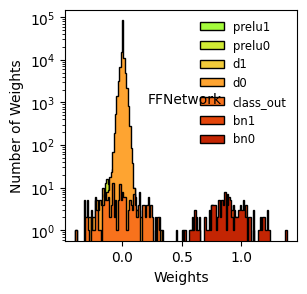

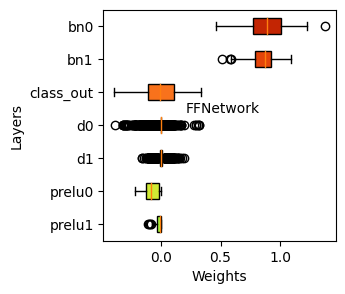

In [11]:
if train:
    utils.plot_metrics(model,metric='loss')
    utils.plot_metrics(model,metric='accuracy')
    utils.plot_metrics(model,metric='AUC')
    model.network.load_weights('./weights/FFNN/model_weights.h5')

utils.doWeights(model, log=True, figsize=(3,3))
utils.WhiskerWeights(model, figsize=(3,3))

### Model Evaluation

2092/2092 [==============================] - 10s 5ms/step
 
 Prediction: 
 [[0.02096169 0.07714972 0.90188855]
 [0.05832429 0.18777129 0.75390446]
 [0.0721866  0.14684708 0.78096634]
 ...
 [0.07739219 0.26366225 0.6589456 ]
 [0.02410371 0.11977256 0.8561237 ]
 [0.08482371 0.16051735 0.754659  ]]

 True labels: 
 [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]

 Indices of uncorrectly predicted samples:
Predictions: [2 2 2 ... 2 2 2]
True Labels: [2 1 2 ... 2 2 0]

 Accuracy: 64.84068059933375 %


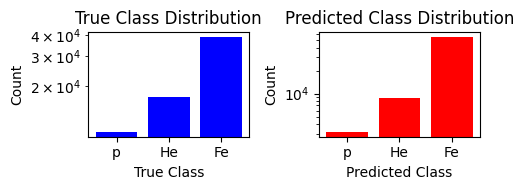

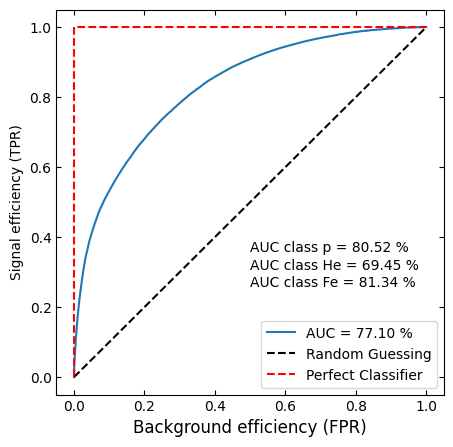

<Figure size 800x600 with 0 Axes>

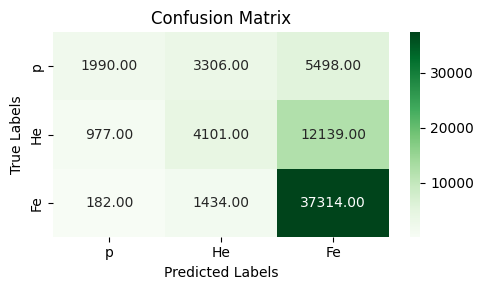

In [12]:
predictions = model.predict(x_valid)
correct_predictions = []

for i in range(len(predictions)):
    predicted_class = np.argmax(predictions[i])
    true_class = np.argmax(y_valid[i])

    if predicted_class == true_class:
        correct_predictions.append(i)

print(f' \n Prediction: \n {predictions}')
print('\n True labels: \n', y_valid)
print("\n Indices of uncorrectly predicted samples:")
# print(correct_predictions)


predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_valid, axis=1)

print("Predictions:", predicted_labels)
print("True Labels:", true_labels)
accuracy = np.mean(predicted_labels == true_labels) * 100
print("\n Accuracy:", accuracy, "%")

utils.visualize_class_distribution( y_valid, predictions, figsize=(5, 2))
utils.plot_auc( y_valid, predictions) # BEST: auc =  77 %
utils.plot_confusion_matrix( y_valid, predictions)

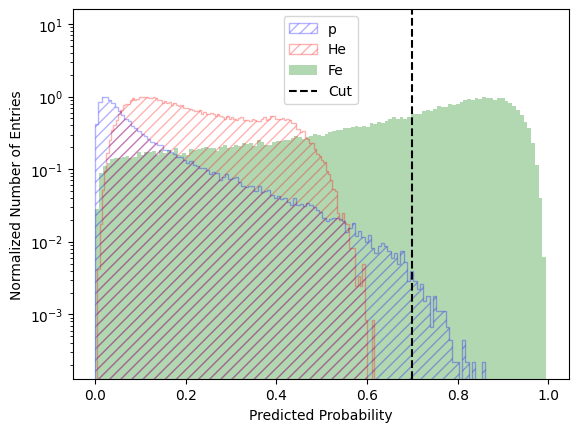

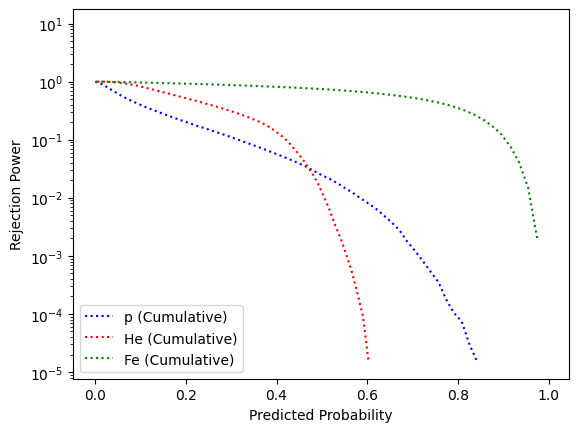

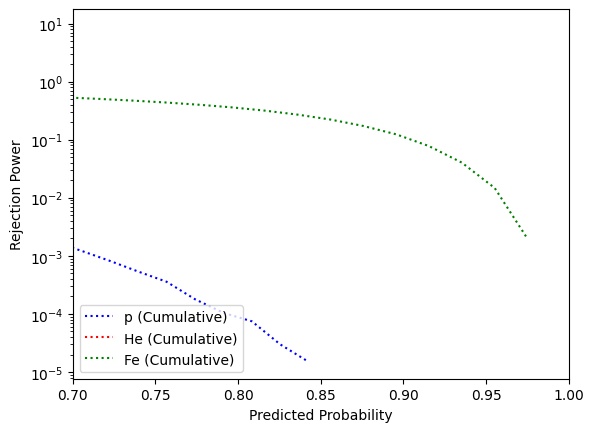

In [17]:
plots.plot_normalized_histogram(predictions,  prob_cut=0.7)  # Replace "Your Proper Description" with the actual description.
plots.plot_cumulative(predictions)
plots.plot_cumulative(predictions,prob_cut = 0.7)

## Ensemble FFN

In [25]:
from ad.models.EnsembleFNN import EnsembleFFNN

num_models = 5
num_classes = 3
epochs = 10

# BEST
batch_sizes =    [128,  256,  512,   64,   32 ] 
print(f"the batch sizes are: {batch_sizes}")

# Define hyperparameter values for each model
#learning_rates = [ 1e-3, 1e-2, 1e-1, 1e-4, 1e-5 ] #0.001, 0.01, 0.1, 0.0001, 1e-5
#print(f"the learning rates are: {learning_rates}")

#kernel_initializers = ['he_uniform', 'glorot_uniform', 'random_normal', 'lecun_normal', 'he_normal']
#print(f"the different kernel initializers are: {kernel_initializers}")


# Create an instance of EnsembleFFNN with different models
ensemble_model = EnsembleFFNN(
                                num_models=num_models, 
                                num_classes=num_classes,
                                batch_sizes=batch_sizes, 
                                #learning_rates=learning_rates, 
                                #kernel_initializers=kernel_initializers
                             )
ensemble_model.summary()

the batch sizes are: [128, 256, 512, 64, 32]
Summary of Model 1:
Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1028)]            0         
                                                                 
 d0 (Dense)                  (None, 128)               131712    
                                                                 
 bn0 (BatchNormalization)    (None, 128)               512       
                                                                 
 prelu0 (PReLU)              (None, 128)               128       
                                                                 
 d1 (Dense)                  (None, 64)                8256      
                                                                 
 bn1 (BatchNormalization)    (None, 64)                256       
                                                         

In [22]:
# Train the models
ensemble_model.train(X, y, epochs=epochs)

#TODO: make this work
# Evaluate the models
#losses, accuracies = ensemble_model.evaluate(x_valid, y_valid)

# Print the results
#for i in range(num_models):
    #print(f"Model {i+1} - Learning Rate: {learning_rates[i]}, Batch Size: {batch_sizes[i]}")
    #print(f"Loss: {losses[i]}, Accuracy: {accuracies[i]}")
 #   print("\n")


Training Model 1
Epoch 1/10
1569/1569 [==============================] - 38s 22ms/step - loss: 0.8566 - accuracy: 0.6107 - AUC: 0.7915 - prec: 0.7068 - rec: 0.4719 - f1: 0.5573 - val_loss: 0.8415 - val_accuracy: 0.6145 - val_AUC: 0.8005 - val_prec: 0.7416 - val_rec: 0.4432 - val_f1: 0.5897
Epoch 2/10
1569/1569 [==============================] - 33s 21ms/step - loss: 0.8072 - accuracy: 0.6371 - AUC: 0.8173 - prec: 0.7266 - rec: 0.5074 - f1: 0.5938 - val_loss: 0.8406 - val_accuracy: 0.6258 - val_AUC: 0.8053 - val_prec: 0.6864 - val_rec: 0.5366 - val_f1: 0.5559
Epoch 3/10
1569/1569 [==============================] - 33s 21ms/step - loss: 0.7870 - accuracy: 0.6474 - AUC: 0.8272 - prec: 0.7334 - rec: 0.5216 - f1: 0.6099 - val_loss: 0.8160 - val_accuracy: 0.6332 - val_AUC: 0.8139 - val_prec: 0.7129 - val_rec: 0.5204 - val_f1: 0.5869
Epoch 4/10
1569/1569 [==============================] - 33s 21ms/step - loss: 0.7680 - accuracy: 0.6575 - AUC: 0.8362 - prec: 0.7385 - rec: 0.5380 - f1: 0.6238 

### Reload model

In [26]:
utils.free_mem()
# Reload the models
ensemble_model = utils.reload_models(ensemble_model.num_models, "./weights/MultiFFNN")

In [27]:
def get_predictions(reloaded_models, X):
    individual_predictions = []
    for model in reloaded_models:
        individual_predictions.append(model.predict(X))
    
    average_prediction = np.mean(individual_predictions, axis=0)
    
    return average_prediction

predictions_ensemble = get_predictions(ensemble_model, x_valid)

2092/2092 [==============================] - 15s 7ms/step


### Model Evaluation

 
 Prediction: 
 [[0.02096169 0.07714972 0.90188855]
 [0.05832429 0.18777129 0.75390446]
 [0.0721866  0.14684708 0.78096634]
 ...
 [0.07739219 0.26366225 0.6589456 ]
 [0.02410371 0.11977256 0.8561237 ]
 [0.08482371 0.16051735 0.754659  ]]

 True labels: 
 [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
The percentage of uncorrect prediction: 35.16 % 


Predictions: [2 2 2 ... 2 2 2]
True Labels: [2 1 2 ... 2 2 0]

 Model accuracy_valid: 64.84068059933375 %


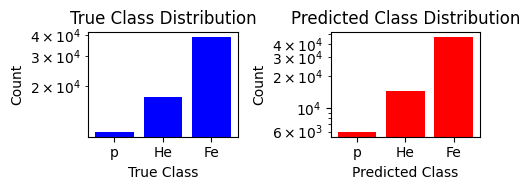

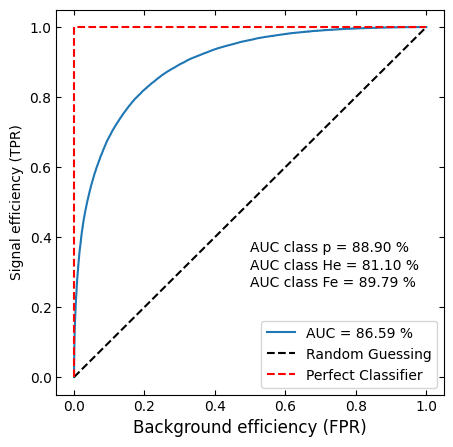

<Figure size 800x600 with 0 Axes>

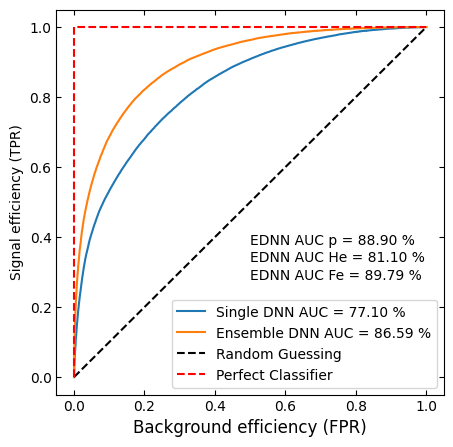

<Figure size 800x600 with 0 Axes>

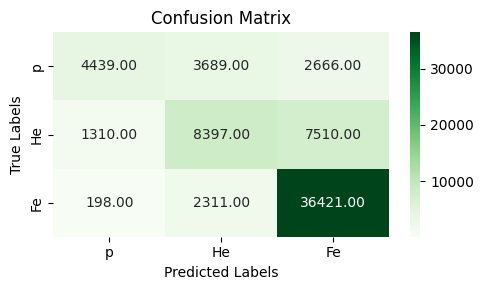

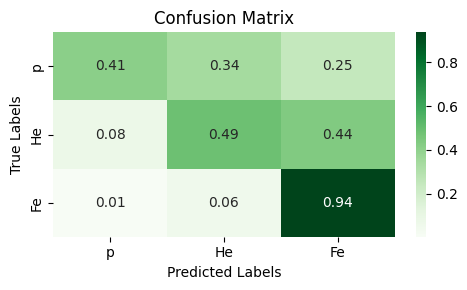

In [29]:
uncorrect_predictions = []

for i in range(len(predictions)):
    predicted_class = np.argmax(predictions[i])
    true_class = np.argmax(y_valid[i])

    if predicted_class != true_class:
        uncorrect_predictions.append(i)

print(f' \n Prediction: \n {predictions}')
print('\n True labels: \n', y_valid)
# print(f"\n Indices of uncorrectly_valid predicted samples: \n{uncorrect_predictions}")
print(f"The percentage of uncorrect prediction: {(len(uncorrect_predictions)/x_valid.shape[0])*100:.2f} % \n\n")

predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_valid, axis=1)

print("Predictions:", predicted_labels)
print("True Labels:", true_labels)
accuracy_valid = np.mean(predicted_labels == true_labels) * 100
print("\n Model accuracy_valid:", accuracy_valid, "%")

utils.visualize_class_distribution( y_valid, predictions_ensemble , figsize=(5, 2))
utils.plot_auc( y_valid, predictions_ensemble ) # BEST: auc =  86 %
utils.plot_auc_compared(y_valid, predictions, predictions_ensemble)
utils.plot_confusion_matrix( y_valid, predictions_ensemble )
utils.plot_confusion_matrix( y_valid, predictions_ensemble , normalize=True)

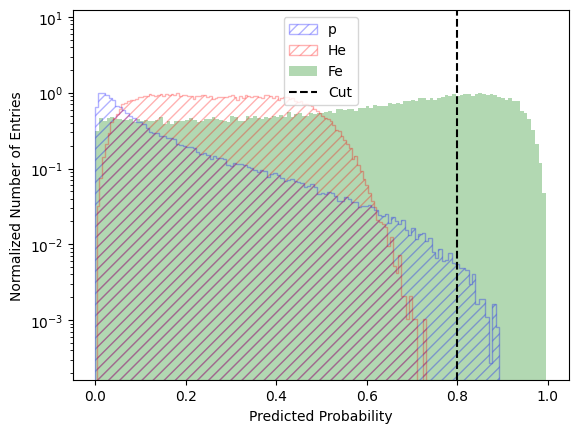

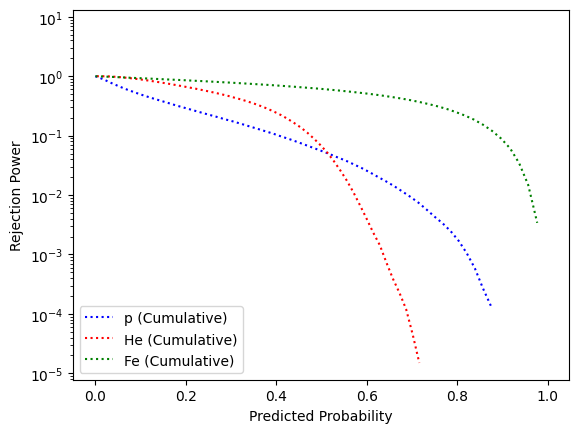

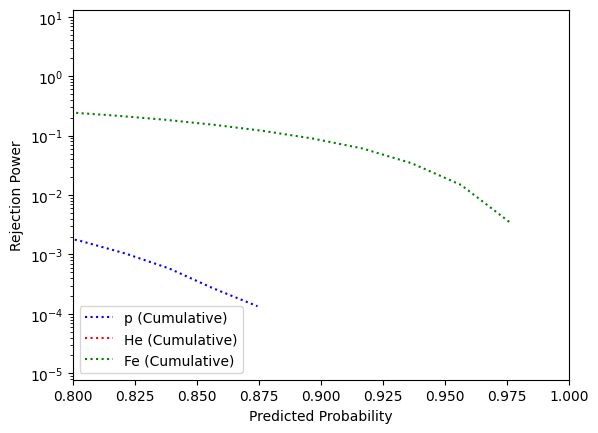

In [34]:
plots.plot_normalized_histogram(predictions_ensemble,  prob_cut=0.8) 
plots.plot_cumulative(predictions_ensemble)
plots.plot_cumulative(predictions_ensemble,prob_cut = 0.8)

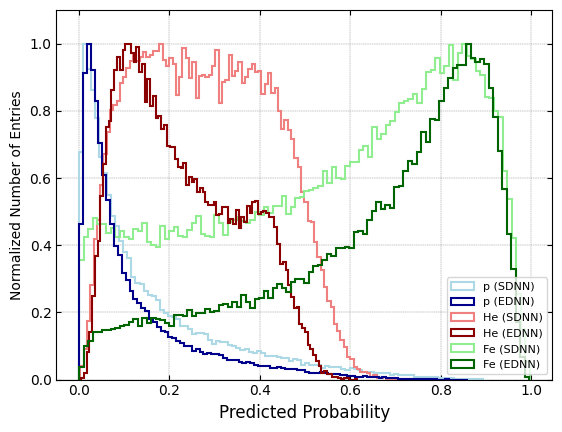

<Figure size 800x600 with 0 Axes>

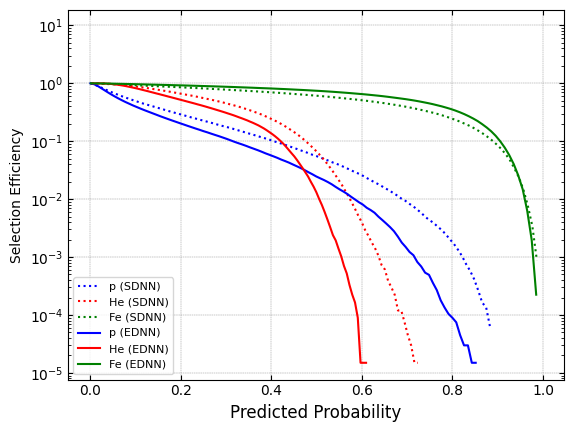

<Figure size 800x600 with 0 Axes>

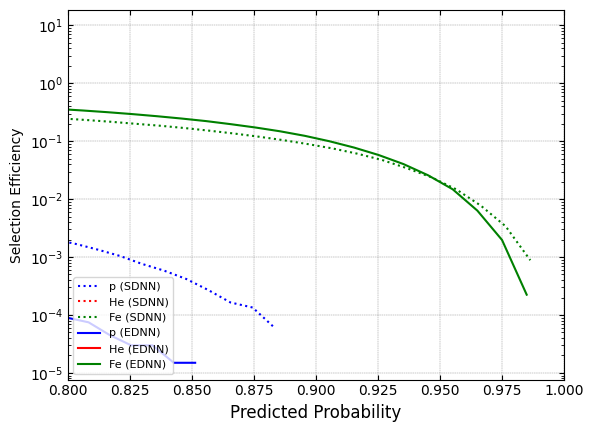

<Figure size 800x600 with 0 Axes>

In [38]:
plots.plot_compared_histograms( predictions_ensemble, predictions )
plots.plot_rejection_power(  predictions_ensemble, predictions)
plots.plot_rejection_power(  predictions_ensemble, predictions, 0.8)

# Convolutional Neural Network Model

In [ ]:
from ad.models.CNN import CNN

model = CNN (
            name='CNNetwork',
            num_classes=3,
            network=dict(
                        activation=tf.keras.activations.relu,
                        input_shape=(1, 1028, 1)
            )
        )
model.summary()


Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 in (InputLayer)             [(None, 1, 1028, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 1, 1028, 32)       320       
                                                                 
 BN1 (BatchNormalization)    (None, 1, 1028, 32)       128       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 1, 514, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 1, 514, 64)        18496     
                                                                 
 BN2 (BatchNormalization)    (None, 1, 514, 64)        256       
                                                                 
 maxpool2 (MaxPooling2D)     (None, 1, 257, 64)        0

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], 1))
x_valid = np.reshape(x_valid, (x_valid.shape[0], 1, x_valid.shape[1], 1))
print(x_train.shape, x_valid.shape)

(250012, 1, 1028, 1) (62504, 1, 1028, 1)


In [39]:
# train = True

# # Compile the model
# model.network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                       loss='sparse_categorical_crossentropy',
#                       metrics=['accuracy'])
# if train:
#     # Train the model
#     model.train(x_train, y_train, x_valid, y_valid, epochs=10, batch_size=256)
#     # Save the model weights
#     model.network.save_weights('./weights/CNN.h5')
# else: 
#     # Load the saved model weights
#     model.network.load_weights('./weights/CNN.h5')

# # Evaluate the model on the test set
# test_loss, test_accuracy = model.network.evaluate(x_valid, y_valid)
# print('Test loss:', test_loss)
# print('Test accuracy:', test_accuracy)

# print(model.predict(x_valid))
# print(y_valid)